In [2]:
%run StoreTweetsBackend.ipynb

Growth SET
GPU ACTIVE
{'limit': 15, 'remaining': 15, 'reset': 1618823494}
{'limit': 900, 'remaining': 900, 'reset': 1618823494}
sentimentDB exists.
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'sentimentDB')


In [ ]:
!conda install seaborn 

In [3]:
stockData= pd.read_csv("project/archive/Stocks/tsla.us.txt",parse_dates=[0])
print(stockData['Date'].min(), stockData['Date'].max())
cols = [ "OpenInt"]
# cols = [ "Date","Open","High","Low","Close","Volume","OpenInt"]
stockData.drop(cols, axis=1, inplace=True)
stockData = stockData.sort_values('Date')
stockData.isnull().sum()
stockData["Date"]

2010-06-28 00:00:00 2017-11-10 00:00:00


0      2010-06-28
1      2010-06-29
2      2010-06-30
3      2010-07-01
4      2010-07-02
          ...    
1853   2017-11-06
1854   2017-11-07
1855   2017-11-08
1856   2017-11-09
1857   2017-11-10
Name: Date, Length: 1858, dtype: datetime64[ns]

In [4]:
stockData

,Date,Open,High,Low,Close,Volume
0,2010-06-28,17.00,17.00,17.00,17.00,0
1,2010-06-29,19.00,25.00,17.54,23.89,18783276
2,2010-06-30,25.79,30.42,23.30,23.83,17194394
3,2010-07-01,25.00,25.92,20.27,21.96,8229863
4,2010-07-02,23.00,23.10,18.71,19.20,5141807
...,...,...,...,...,...,...
1853,2017-11-06,307.00,307.50,299.01,302.78,6482486
1854,2017-11-07,301.02,306.50,300.03,306.05,5286320
1855,2017-11-08,305.50,306.89,301.30,304.31,4725510
1856,2017-11-09,302.50,304.46,296.30,302.99,5440335


In [3]:
rng=pd.date_range(stockData['Date'].min(), stockData['Date'].max())
# rnglist=rng.tolist()
# testpts = range(100,121)

In [4]:
print(rng[0].strftime('%Y-%m-%d'),stockData["Date"][0])
for i in rng:
    if((rng[0].strftime('%Y-%m-%d')==stockData["Date"]).sum()>1):
        print ((rng[0].strftime('%Y-%m-%d')==stockData["Date"]).sum())
    elif((rng[0].strftime('%Y-%m-%d')==stockData["Date"]).sum()==0):
        print ("missing data: ",rng[0].strftime('%Y-%m-%d'))

2010-06-28 2010-06-28 00:00:00


In [5]:
# rng=pd.date_range(stockData['Date'].min(), stockData['Date'].max())
# stockData["Date"][0]
stockData["Date"][0]

Timestamp('2010-06-28 00:00:00')

In [6]:
# datetime.date(2015,1,1) + timedelta(years=+1)
# print(rnglist[0],stockData['Date'].min())
# datetime.datetime.fromtimestamp(rnglist[0]).Date==stockData['Date'].min()

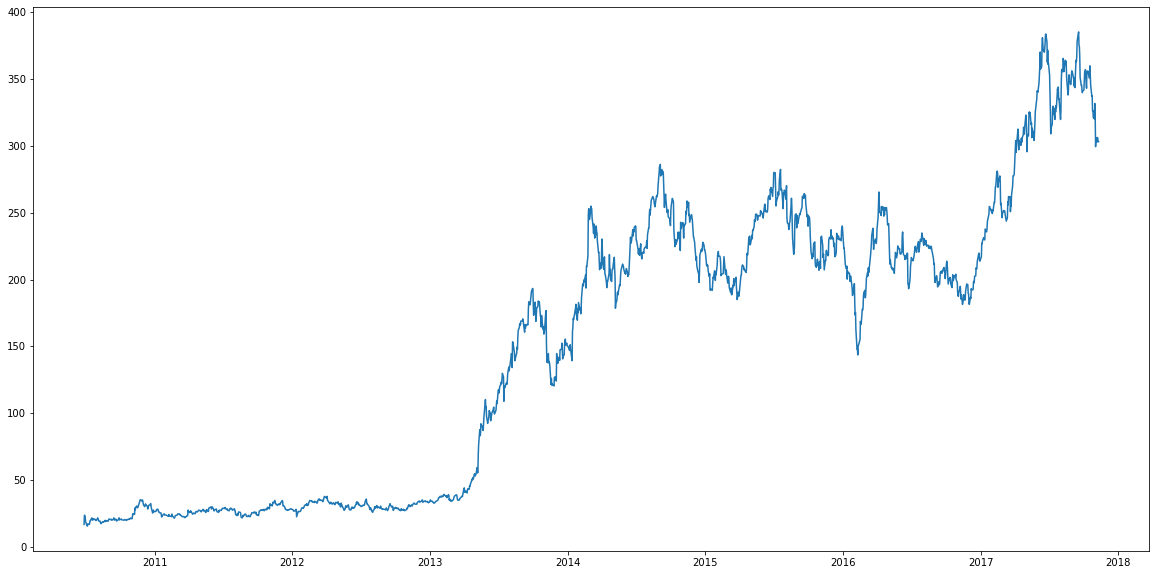

In [7]:
format = '%Y-%m-%d'
stockData['Datetime'] = pd.to_datetime(stockData['Date'] , format=format)
stockData = stockData.set_index(pd.DatetimeIndex(stockData['Datetime']))
stockData.drop(columns=['Datetime','Date'], inplace=True)
plt.figure(figsize=(20,10))
plt.plot(stockData["Close"])

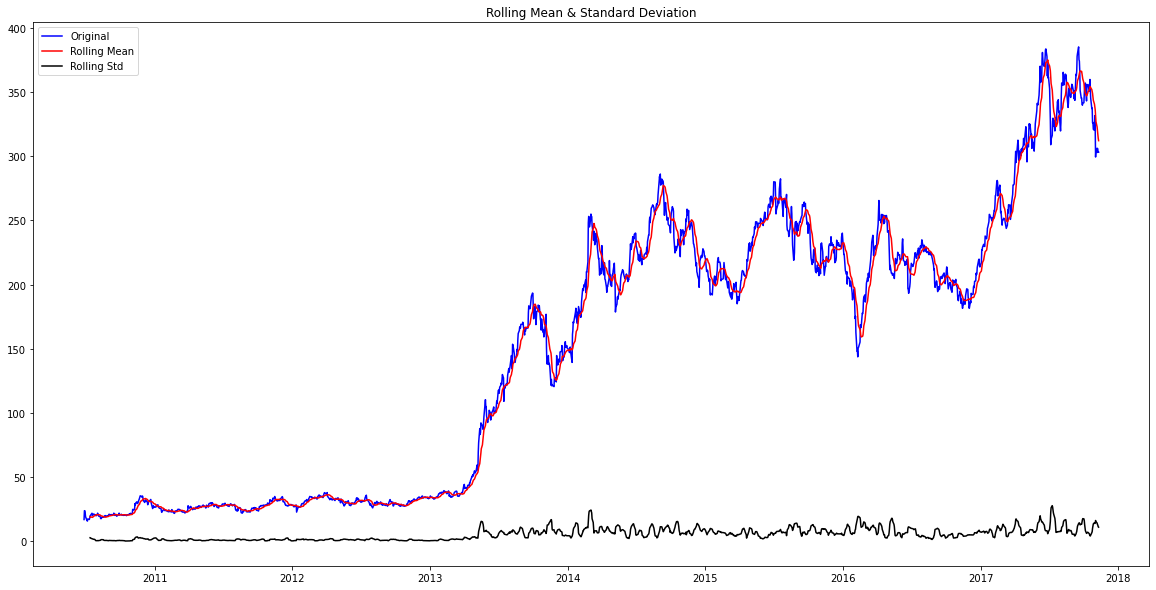

Results of Dickey-Fuller Test:
Test Statistic                   -0.842866
p-value                           0.806205
#Lags Used                        1.000000
Number of Observations Used    1856.000000
Critical Value (1%)              -3.433878
Critical Value (5%)              -2.863099
Critical Value (10%)             -2.567600
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(data,x="Close",period=12):
    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    r=data.rolling(period)
    plt.plot(data[x], color='blue',label='Original')
    plt.plot(r.mean()[x], color='red', label='Rolling Mean')
    plt.plot(r.std()[x], color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(data[x], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


test_stationarity(stockData,x="Close",period=12) 

Text(0.5, 1.0, 'Log')

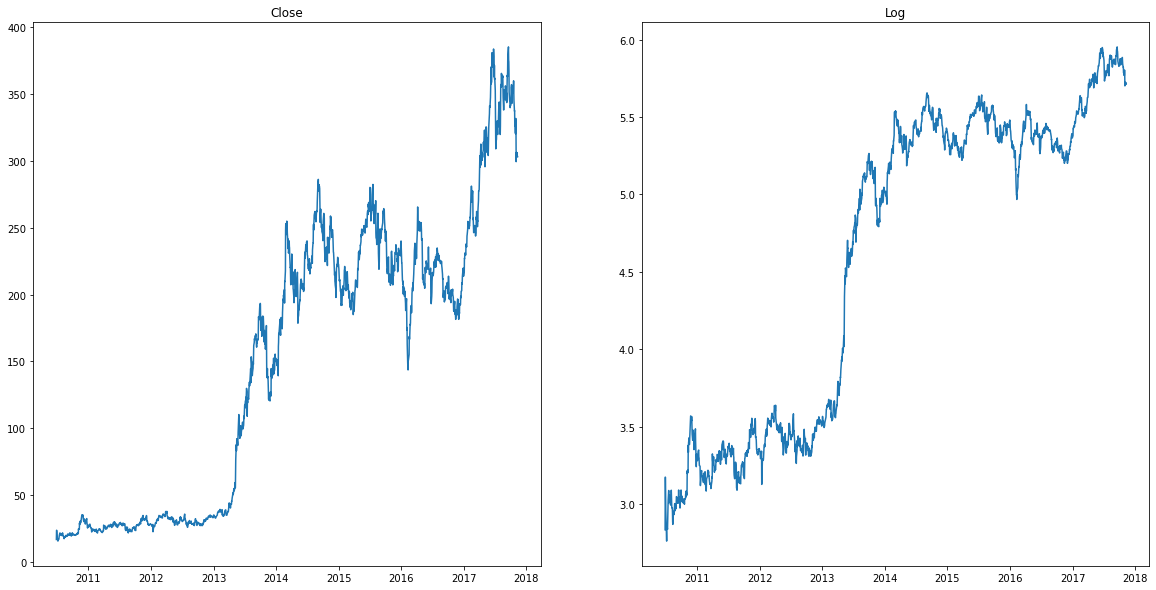

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot((stockData["Close"]))
plt.title("Close")
plt.subplot(122)
plt.plot(np.log(stockData["Close"]))
plt.title("Log")


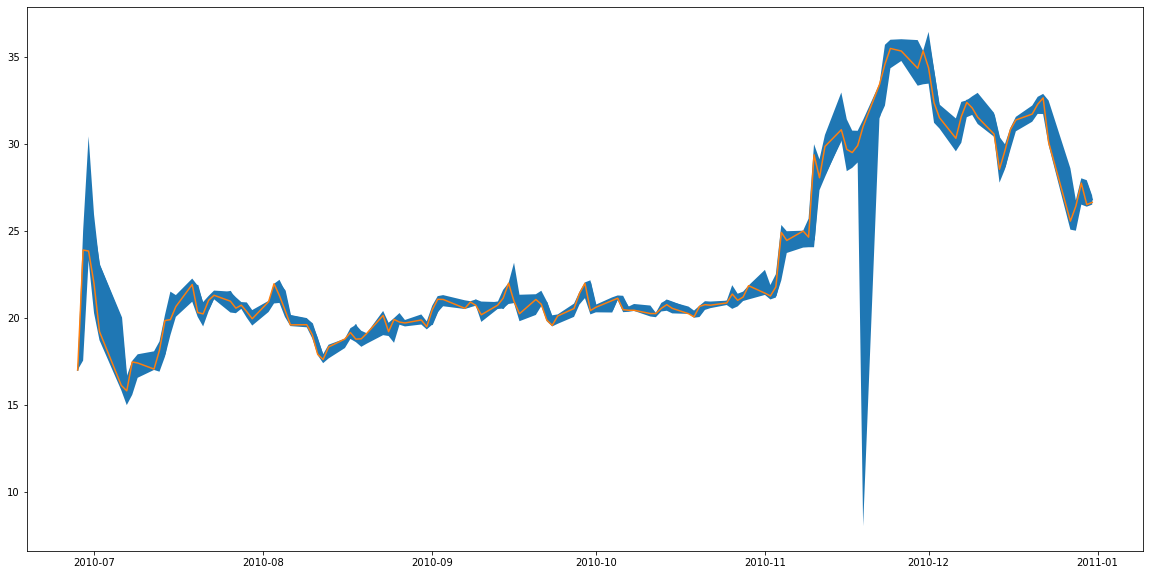

In [10]:
plt.figure(figsize=(20,10))
plt.plot(stockData.loc["2010"]["Open"])
plt.plot(stockData.loc["2010"]["Close"])
plt.fill_between(stockData.loc["2010"].index,stockData.loc["2010"]["Low"], stockData.loc["2010"]["High"])
# plt.plot(stockData.loc["2010"]["Date"],stockData.loc["2010"]["High"])
# plt.plot(stockData.loc["2010"]["Date"],stockData.loc["2010"]["Low"])

<ipython-input-11-7ccc288345d8>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  result_add = seasonal_decompose(x=stockData["2013"]['Close'], model='additive', extrapolate_trend='freq', period=30)


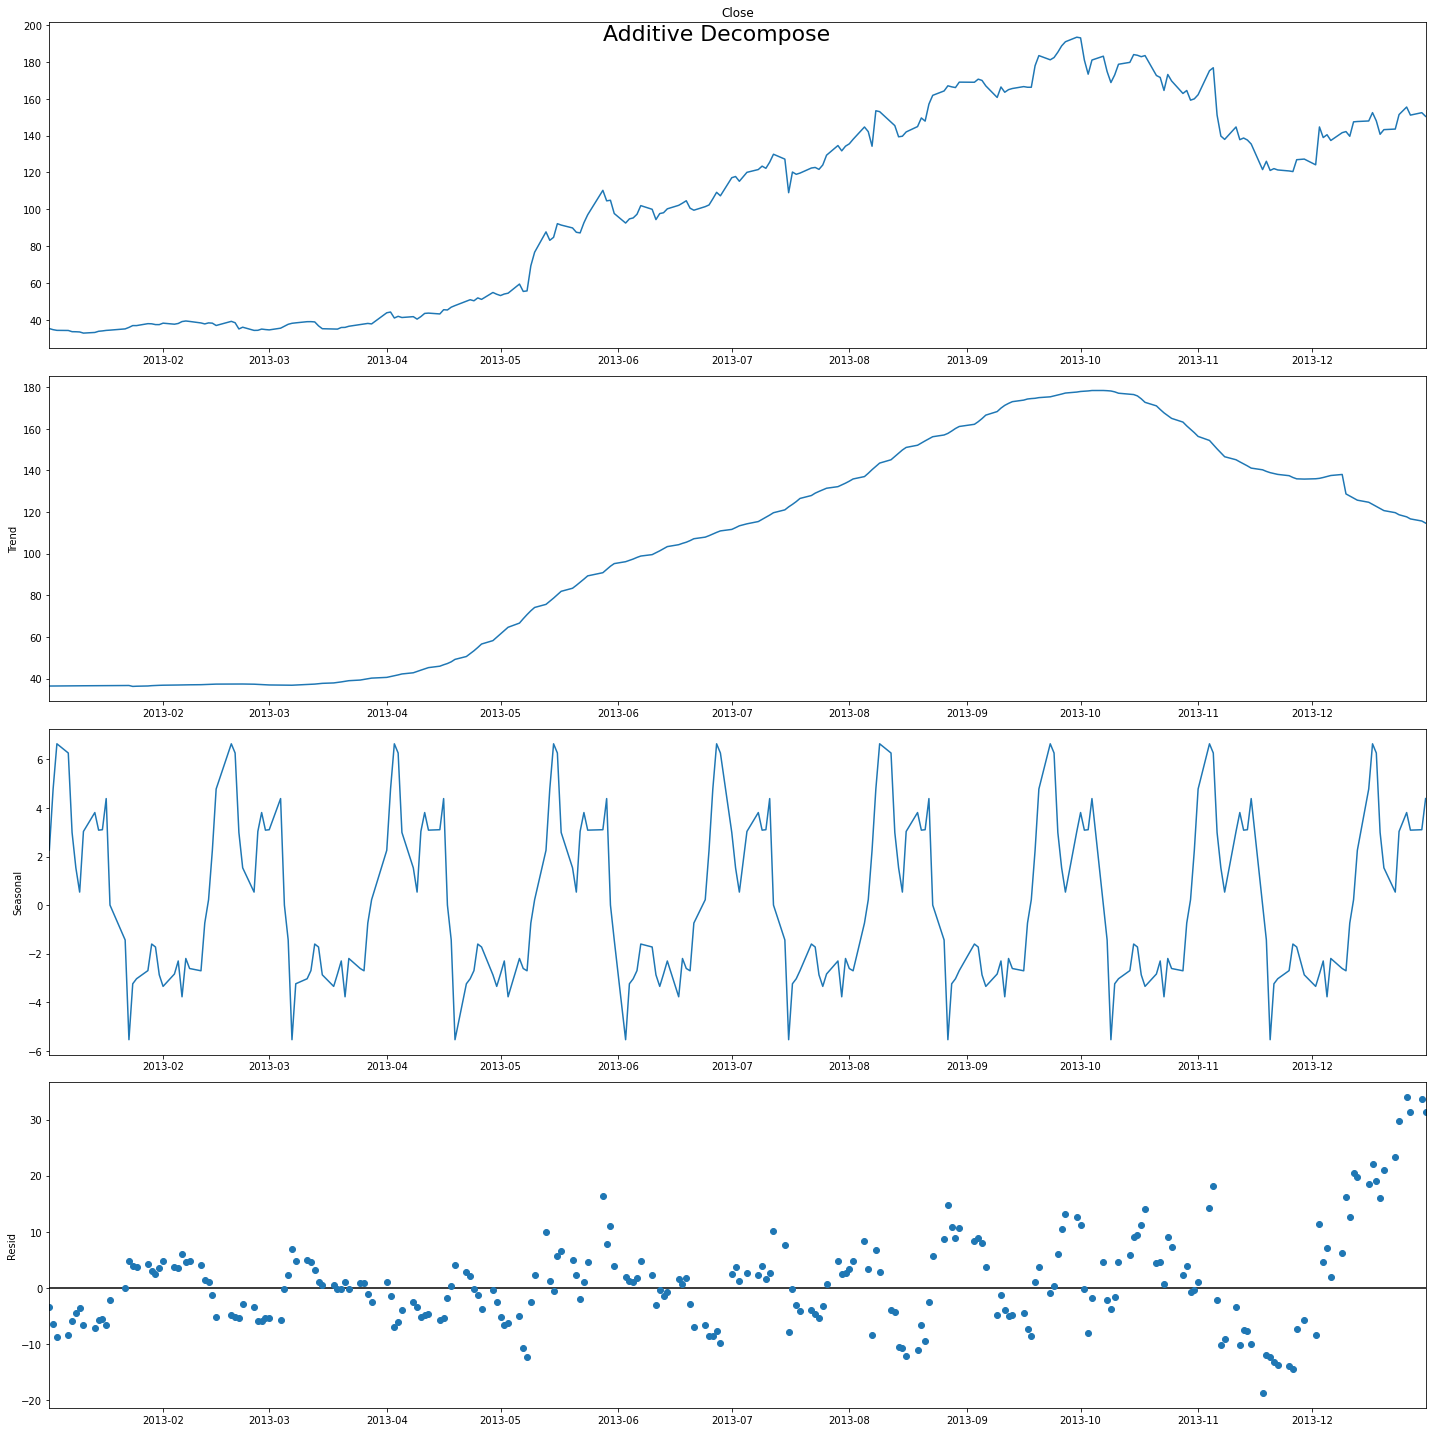

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(x=stockData["2013"]['Close'], model='additive', extrapolate_trend='freq', period=30)
plt.rcParams.update({'figure.figsize': (20,20)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

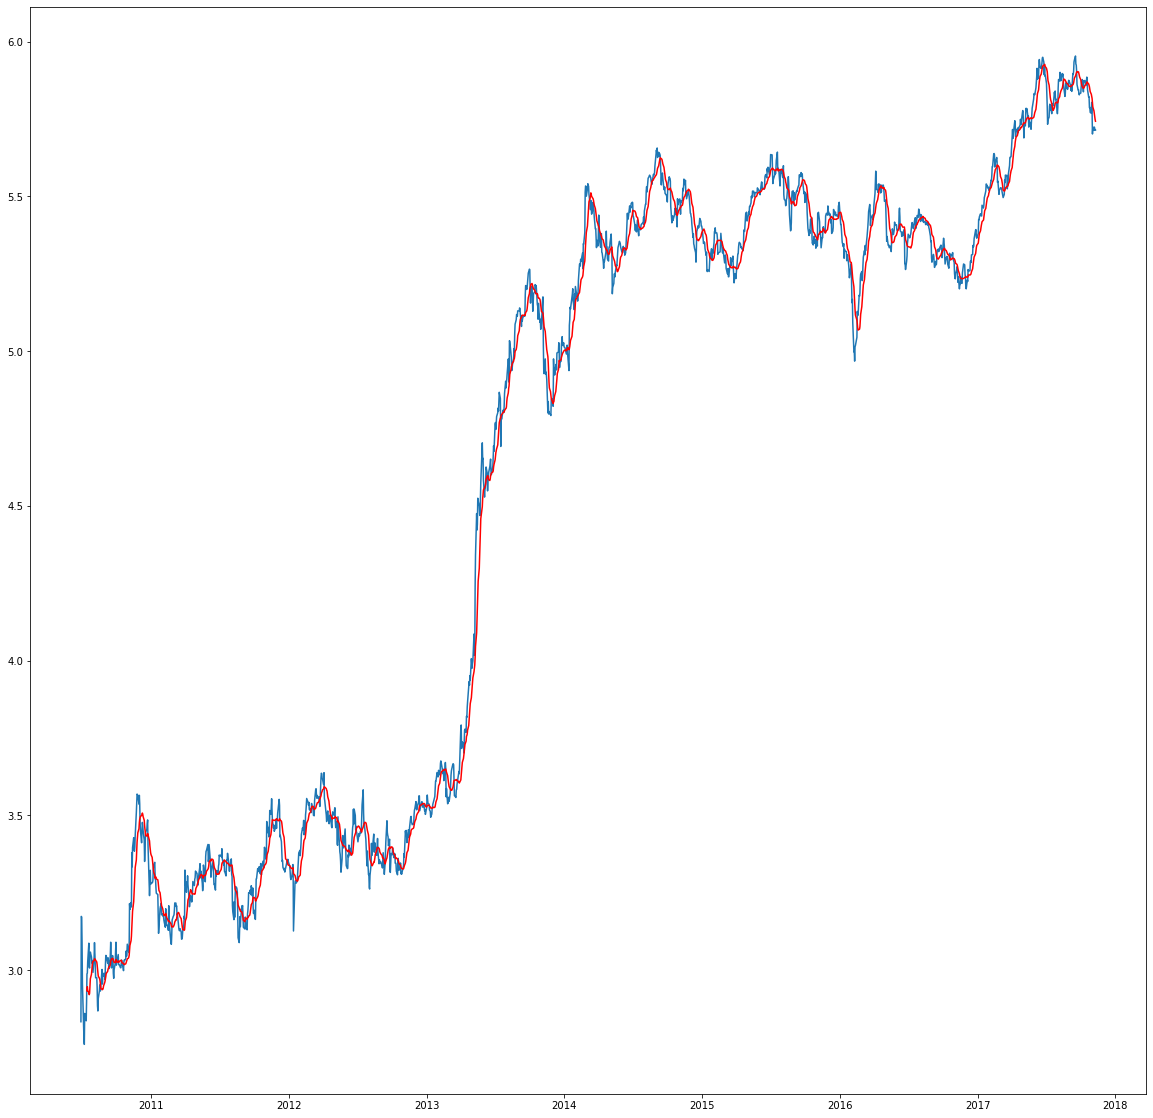

In [12]:
stockDataLog=np.log(stockData)
rolling_windows=stockDataLog.rolling(12)
moving_avg = rolling_windows.mean()
plt.plot(stockDataLog["Close"])
plt.plot(moving_avg["Close"], color='red')

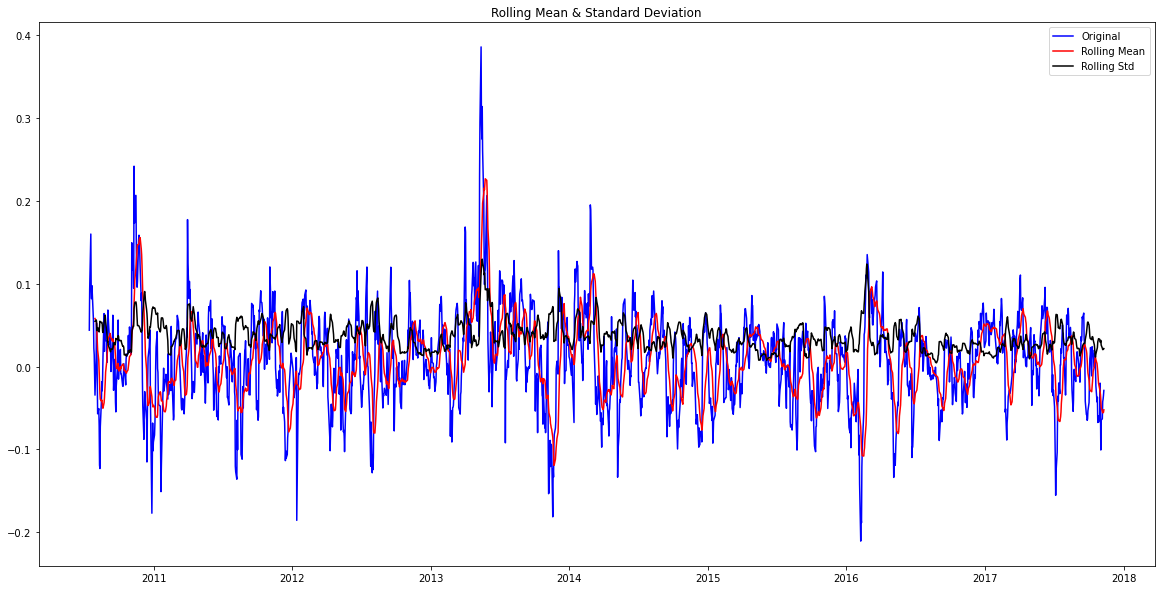

Results of Dickey-Fuller Test:
Test Statistic                -1.199325e+01
p-value                        3.481204e-22
#Lags Used                     5.000000e+00
Number of Observations Used    1.840000e+03
Critical Value (1%)           -3.433909e+00
Critical Value (5%)           -2.863112e+00
Critical Value (10%)          -2.567607e+00
dtype: float64


In [13]:
ts_log_moving_avg_diff = stockDataLog - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
 
test_stationarity(ts_log_moving_avg_diff,x="Close",period=12)

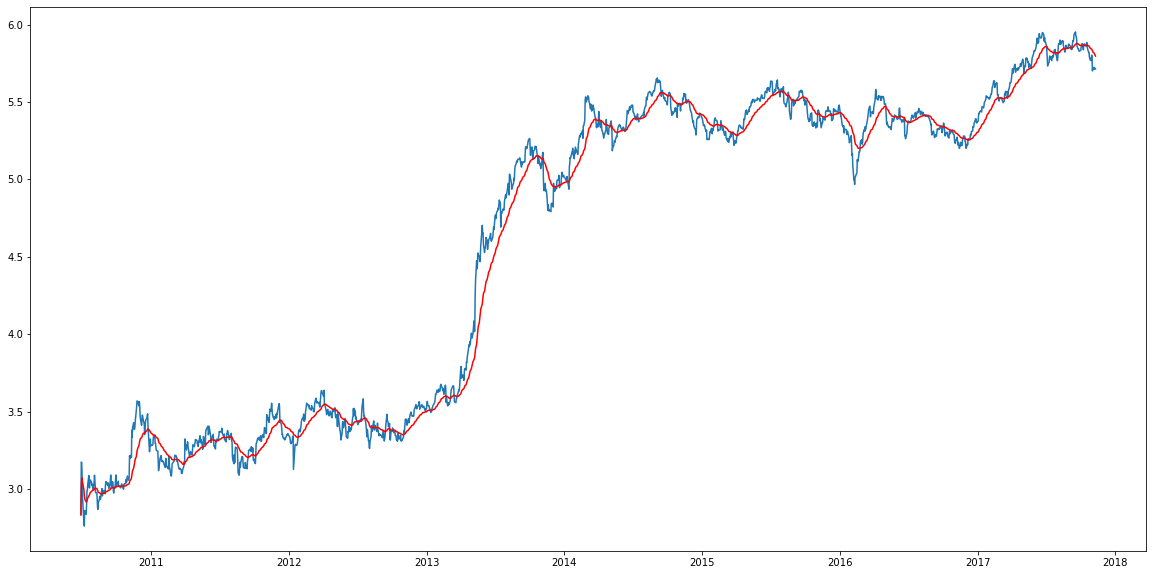

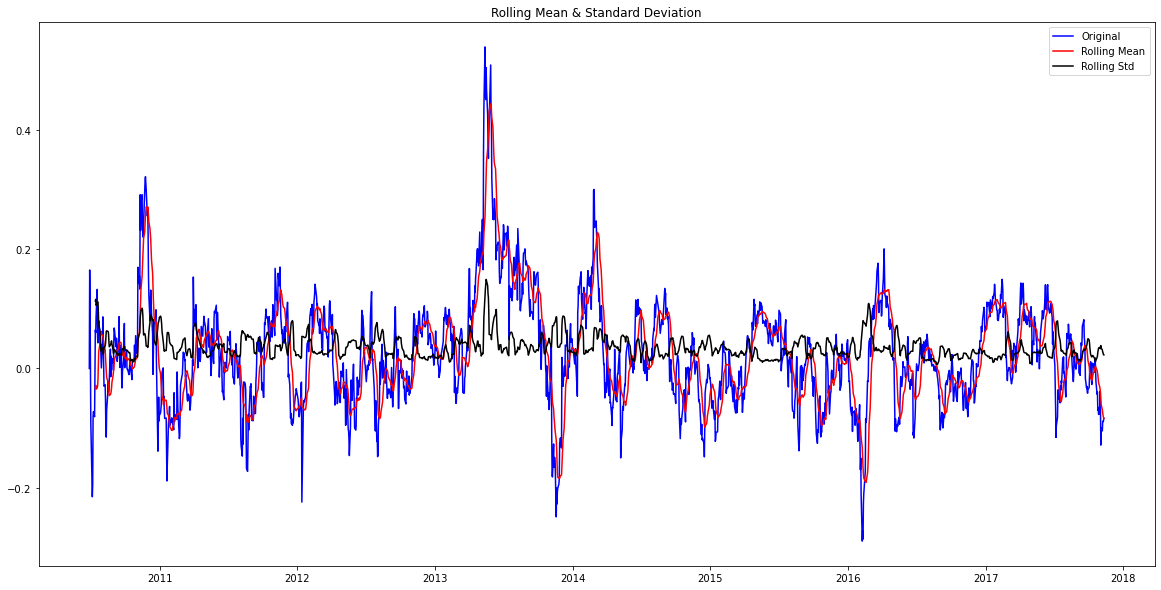

Results of Dickey-Fuller Test:
Test Statistic                -7.369205e+00
p-value                        9.065364e-11
#Lags Used                     0.000000e+00
Number of Observations Used    1.857000e+03
Critical Value (1%)           -3.433876e+00
Critical Value (5%)           -2.863098e+00
Critical Value (10%)          -2.567599e+00
dtype: float64


In [14]:
expwighted_avg = stockDataLog.ewm(halflife=12).mean()
plt.figure(figsize=(20,10))
plt.plot(stockDataLog["Close"])
plt.plot(expwighted_avg["Close"], color='red')
ts_log_ewma_diff = stockDataLog - expwighted_avg


test_stationarity(ts_log_ewma_diff,x="Close",period=12)


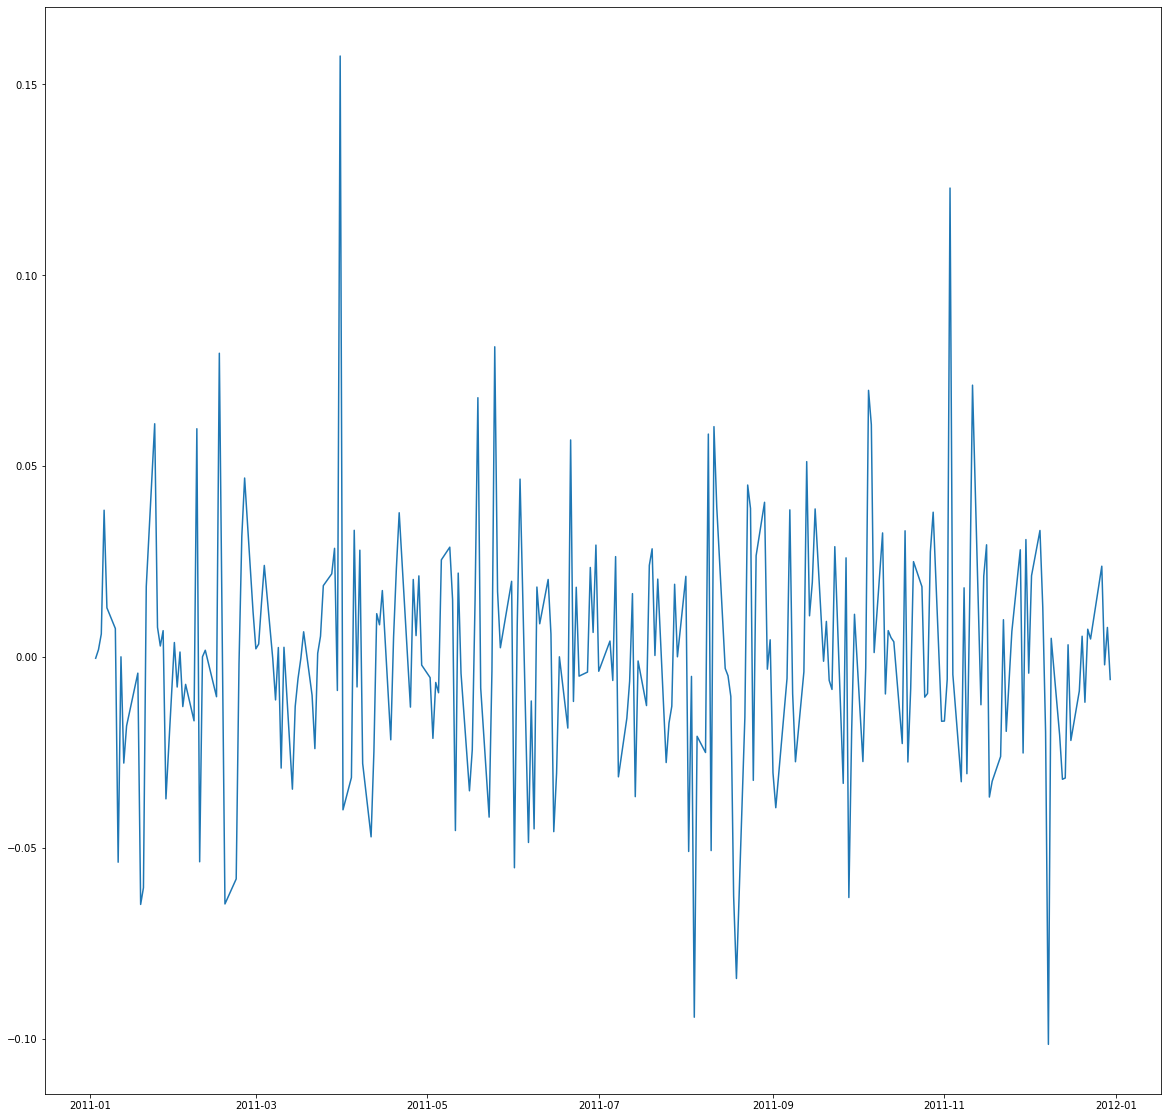

In [15]:
ts_log_diff = stockDataLog - stockDataLog.shift()
plt.plot(ts_log_diff.loc["2011"]["Close"])
ts_log_diff.dropna(inplace=True)


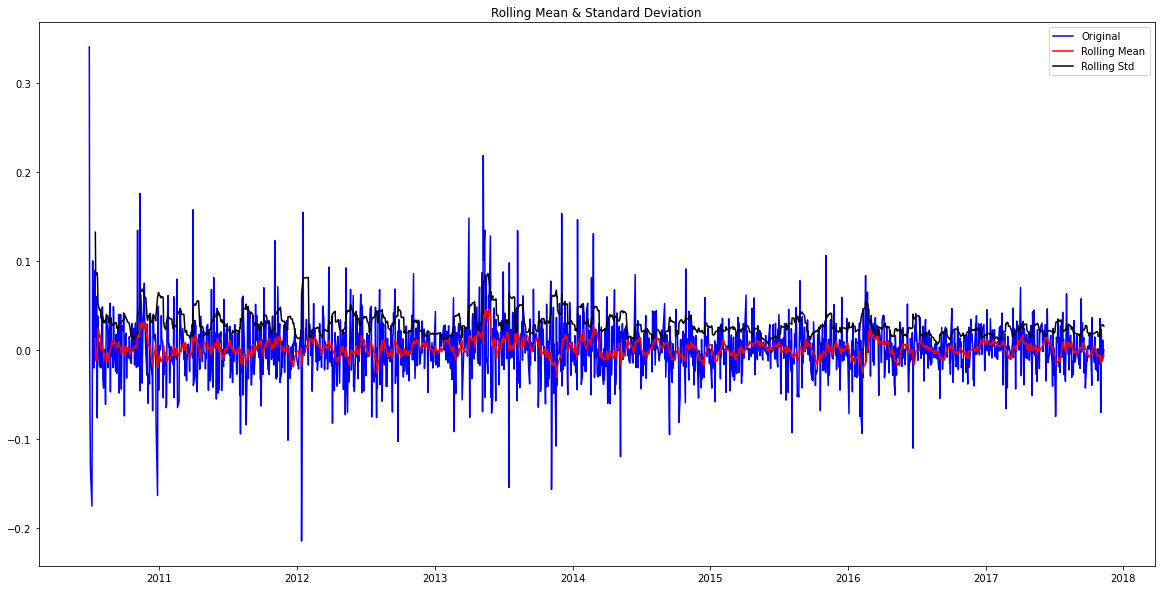

Results of Dickey-Fuller Test:
Test Statistic                  -43.442737
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1856.000000
Critical Value (1%)              -3.433878
Critical Value (5%)              -2.863099
Critical Value (10%)             -2.567600
dtype: float64


In [16]:
test_stationarity(ts_log_diff,"Close")

<ipython-input-17-79f9b30a2795>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  result_add = seasonal_decompose(x=stockDataLog["2013"]['Close'], model='additive', extrapolate_trend='freq', period=30)


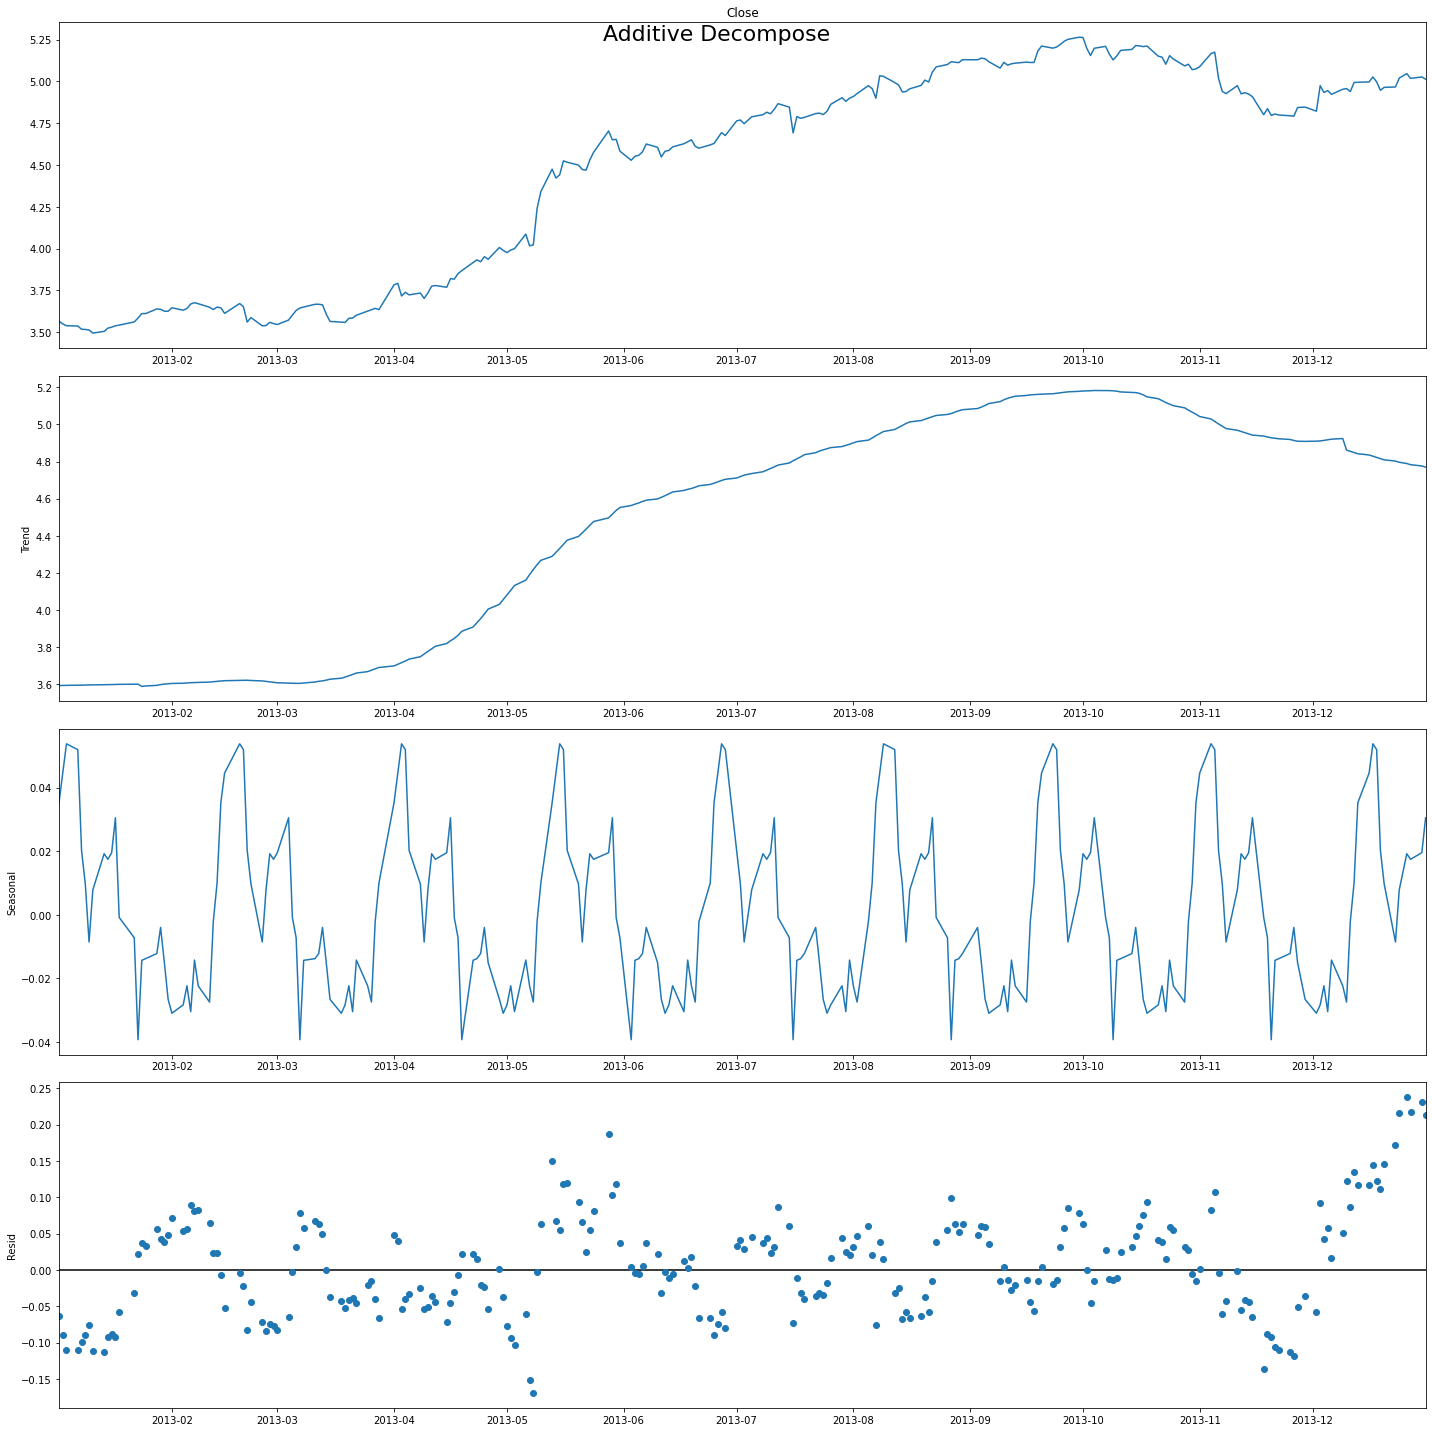

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(x=stockDataLog["2013"]['Close'], model='additive', extrapolate_trend='freq', period=30)
plt.rcParams.update({'figure.figsize': (20,20)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

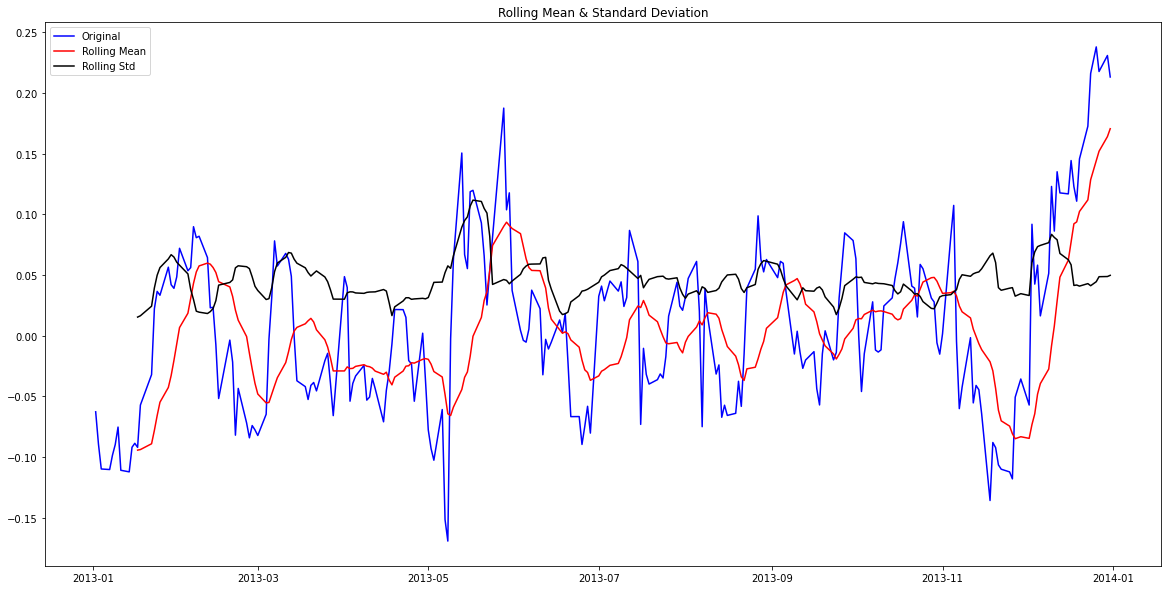

Results of Dickey-Fuller Test:
Test Statistic                  -4.038926
p-value                          0.001220
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [18]:
ts_log_decompose =result_add.resid
ts_log_decompose.dropna(inplace=True)
f=ts_log_decompose.to_frame() 
f=f.rename({"Datetime":'Datetime',"resid":"Close"}, axis='columns')
test_stationarity(f)

In [19]:
ts_log=stockDataLog.loc["2013"]['Close']
ts_log.index = pd.DatetimeIndex(ts_log.index).to_period('D')

C:\Users\mech\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


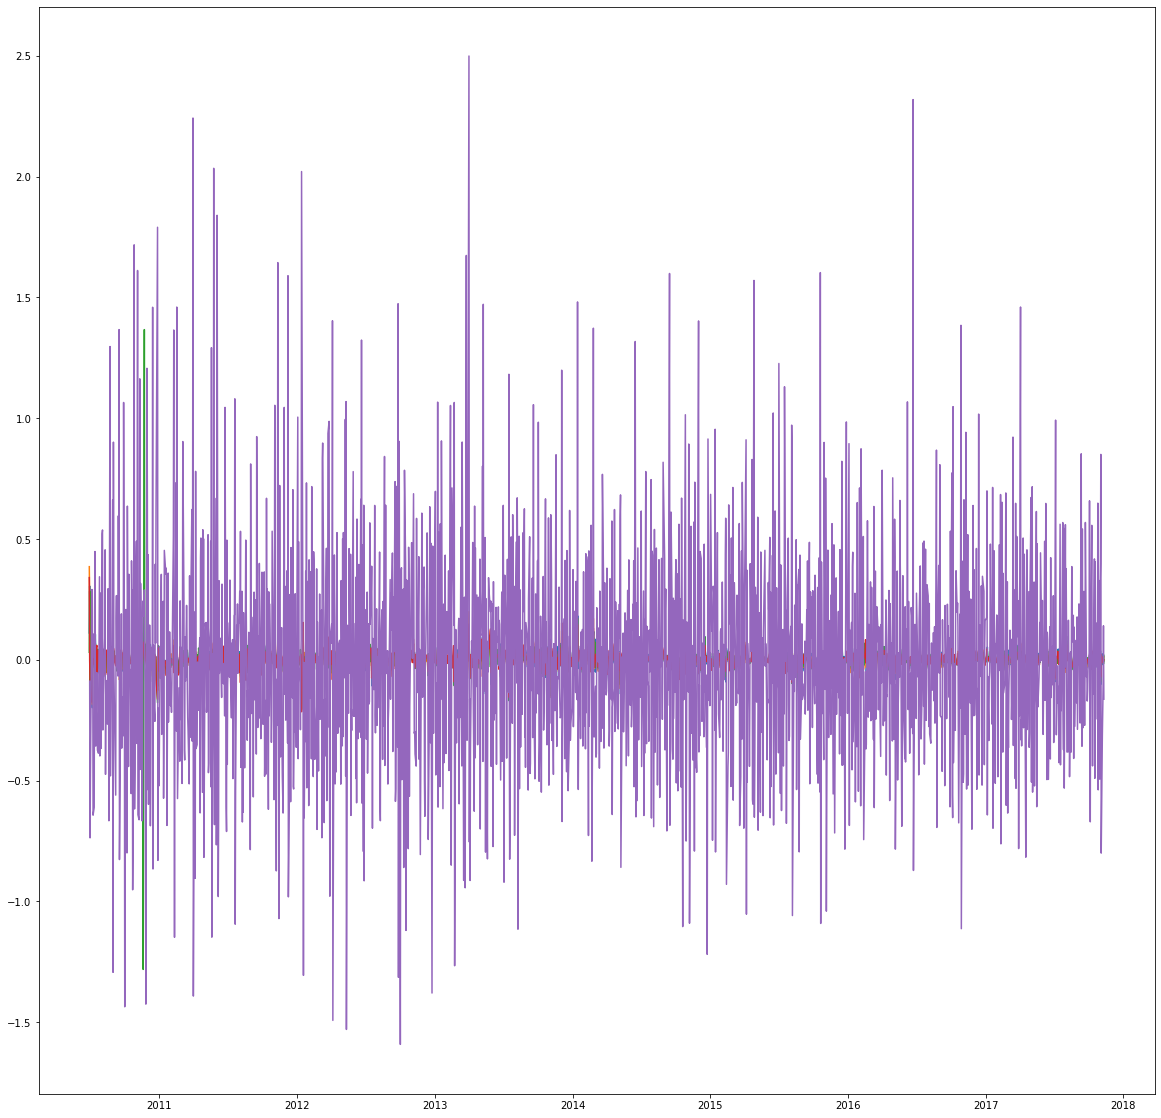

In [20]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)


In [21]:
# plt.plot(results_AR.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [22]:
# model = ARIMA(ts_log, order=(0, 1, 2))  
# results_MA = model.fit(disp=-1)  
# plt.plot(ts_log_diff)


In [ ]:
# ff=results_MA.fittedvalues
# ff=ff.to_timestamp()
# ff=ff
# plt.plot(ff, color='red')
# plt.title('RSS: %.4f'% sum((ff-ts_log_diff.loc["2013"]['Close'])**2))

C:\Users\mech\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\mech\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIM

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

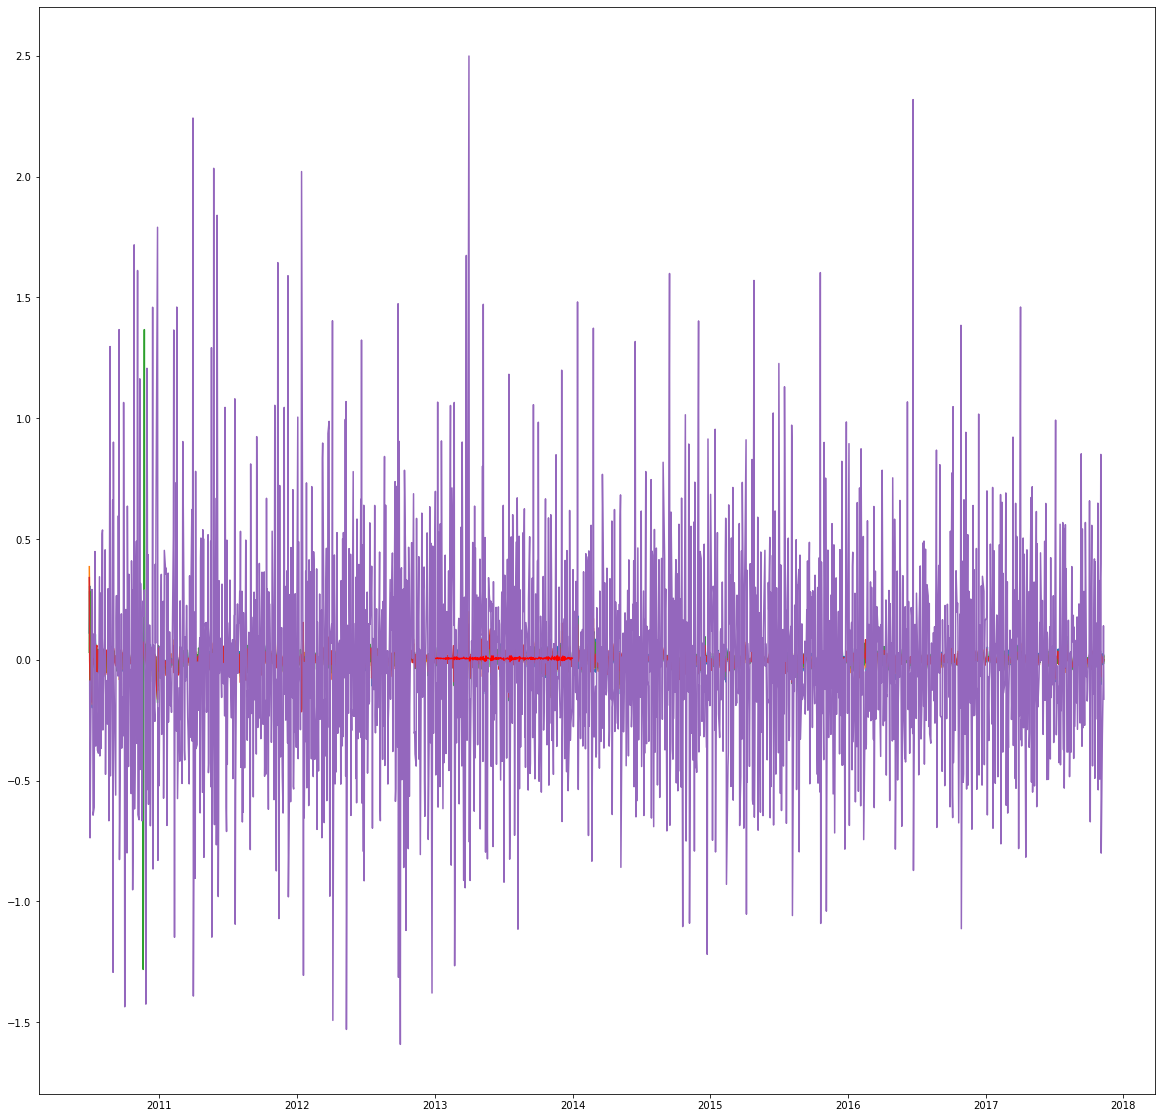

In [23]:
# ts_log_diff=ts_log_diff.loc["2013"]['Close']
# ff=ff
# ff=ff.asfreq('D')
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1).fittedvalues.to_timestamp() 
results_ARIMA=results_ARIMA.asfreq('D')
plt.plot(ts_log_diff)
plt.plot(results_ARIMA, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA-ts_log_diff)**2))